In [52]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

from keras.models import Model
from keras.layers import Lambda, Input, Dense
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

In [53]:
class LoadLaserScans:
    def __init__(self, datafile, clip_scans_at=8, scan_bound_percentage=0.15, verbose=False):
        self.verbose = verbose
        self.data = np.loadtxt(datafile).astype('float32')
        self.clip_scans_at = clip_scans_at
        self.timesteps = self.data[:, :1]
        self.cmd_vel = self.data[:, 1:7]
        self.scans = self.data[:, 7:]
        
        if self.verbose: 
            print("timesteps --", self.timesteps.shape)
            print("cmd_vel --", self.cmd_vel.shape)
            print("scans --", self.scans.shape, "ranges [", np.max(self.scans), "-", np.min(self.scans), "]")
            
        np.clip(self.scans, a_min=0, a_max=clip_scans_at, out=self.scans)
        
        # bounds are due to the embodiment of the particular robot used, this should not exist!!!
        min_bound = int(scan_bound_percentage*self.scans.shape[1])
        max_bound = int(self.scans.shape[1] - scan_bound_percentage*self.scans.shape[1])
        if self.verbose: print("scans bounds (min, max)=", min_bound, max_bound)
        
        self.scans = self.scans[:, min_bound:max_bound] / self.clip_scans_at    # normalization makes the vae work
    
    def originalScansDim(self):
        return self.scans.shape[1]
    
    def timesteps(self):
        return self.timesteps
    
    def cmdVel(self):
        return self.cmd_vel
    
    def getScans(self, split_at=0):
        if split_at == 0: return self.scans
        
        x_train = self.scans[:int(self.scans.shape[0]*split_at),:]
        x_test = self.scans[int(self.scans.shape[0]*split_at):,:]
        
        if self.verbose:
            print("scans train:", x_train.shape)
            print("scans test:", x_test.shape)
            
        return x_train, x_test

In [63]:
class VAE:
    def __init__(self, epochs=10, batch_size=128, latent_dim=10, intermediate_dim=128, verbose=False):
        self.epochs = epochs
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.intermediate_dim = intermediate_dim
        self.verbose = verbose

    def sampling(self, args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
    def buildModel(self, original_dim):
        input_shape = (original_dim, )

        # VAE model = encoder + decoder
        # build encoder model
        inputs = Input(shape=input_shape, name='encoder_input')
        x = Dense(self.intermediate_dim, activation='relu')(inputs)
        z_mean = Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = Dense(self.latent_dim, name='z_log_var')(x)

        # use reparameterization trick to push the sampling out as input
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(self.sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])

        # instantiate encoder model
        self.encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
        if self.verbose: encoder.summary()

        # build decoder model
        latent_inputs = Input(shape=(self.latent_dim,), name='z_sampling')
        x = Dense(self.intermediate_dim, activation='relu')(latent_inputs)
        outputs = Dense(original_dim, activation='sigmoid')(x)

        # instantiate decoder model
        self.decoder = Model(latent_inputs, outputs, name='decoder')
        if self.verbose: decoder.summary()

        # instantiate VAE model
        outputs = self.decoder(self.encoder(inputs)[2])
        self.vae = Model(inputs, outputs, name='vae_mlp')
        
        reconstruction_loss = binary_crossentropy(inputs, outputs)
        reconstruction_loss *= original_dim
        
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        
        self.vae.add_loss(vae_loss)
        self.vae.compile(optimizer='adam')
        if self.verbose: self.vae.summary()
    
    def fitModel(self, x, x_test=None):
        if x_test == None:
            self.vae.fit(x,
                         epochs=self.epochs,
                         batch_size=self.batch_size,
                         verbose=2)
        else:
            self.vae.fit(x,
                         epochs=self.epochs,
                         batch_size=self.batch_size,
                         verbose = 2,
                         validation_data=(x_test, None))
    
    def predictEncoder(self, x, batch_size=1):
        z_mean, _, _ = encoder.predict(x, batch_size=batch_size)
        return z_mean
    
    def predictDecoder(self, z_mean):
        x_decoded = decoder.predict(z_mean)
        return x_decoded

In [55]:
if __name__ == "__main__":
    # ; DIAG_first_floor.txt; diag_labrococo.txt
    ls = LoadLaserScans("../../dataset/diag_underground.txt", verbose=True)

timesteps -- (13545, 1)
cmd_vel -- (13545, 6)
scans -- (13545, 721) ranges [ 30.0 - 0.0 ]
scans bounds (min, max)= 108 612


In [65]:
    vae = VAE()
    vae.buildModel(ls.originalScansDim())
    vae.fitModel(ls.getScans())
    
    x, x_test = ls.getScans(0.9)
    vae.fitModel(x, x_test=x_test)

Epoch 1/10
 - 1s - loss: 294.8138
Epoch 2/10
 - 1s - loss: 275.7877
Epoch 3/10
 - 1s - loss: 272.2783
Epoch 4/10
 - 1s - loss: 270.6009
Epoch 5/10
 - 1s - loss: 269.4026
Epoch 6/10
 - 1s - loss: 268.6435
Epoch 7/10
 - 1s - loss: 268.0669
Epoch 8/10
 - 1s - loss: 267.5504
Epoch 9/10
 - 1s - loss: 267.2242
Epoch 10/10
 - 1s - loss: 266.9125
scans train: (12190, 504)
scans test: (1355, 504)
Train on 12190 samples, validate on 1355 samples
Epoch 1/10


/home/sapienzbot/.local/lib/python3.5/site-packages/ipykernel_launcher.py:61: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


 - 1s - loss: 267.5506 - val_loss: 258.8218
Epoch 2/10
 - 1s - loss: 267.2968 - val_loss: 258.7809
Epoch 3/10
 - 1s - loss: 267.0810 - val_loss: 258.5091
Epoch 4/10
 - 0s - loss: 266.9591 - val_loss: 258.8278
Epoch 5/10
 - 0s - loss: 266.8806 - val_loss: 258.4895
Epoch 6/10
 - 0s - loss: 266.7546 - val_loss: 258.5513
Epoch 7/10
 - 0s - loss: 266.6496 - val_loss: 258.4975
Epoch 8/10
 - 0s - loss: 266.4856 - val_loss: 258.6320
Epoch 9/10
 - 0s - loss: 266.4152 - val_loss: 258.4996
Epoch 10/10
 - 0s - loss: 266.3928 - val_loss: 258.4324


In [21]:
scan_idx = 900
lstep = (3/2)*np.pi/720
theta = np.arange(bound*(3/2)*np.pi, (1 - bound)*(3/2)*np.pi, lstep) - bound*(3/2)*np.pi
theta = theta[::-1]

In [22]:
def getScanSegments(scans, threshold):
    segments = []
    iseg = 0
    useg = bool(scans[0] > threshold)
    for d in range(scans.shape[0]):
        if useg and scans[d] < threshold:
            segments.append([iseg, d, useg])
            iseg = d
            useg = False
        if not useg and scans[d] > threshold:
            segments.append([iseg, d, useg])
            iseg = d
            useg = True
        if d == x.shape[0] - 1: segments.append([iseg, d, useg])
    return segments

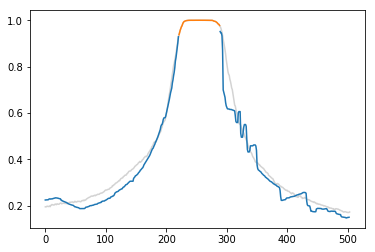

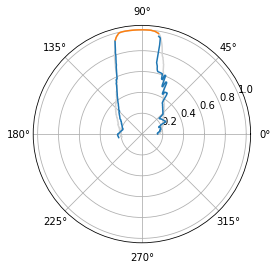

In [14]:
x = np.arange(x_test.shape[1])
segments = getScanSegments(x_test[scan_idx,:], 0.99)
# print(np.array(segments).shape, "--", segments)

plt.figure()
plt.plot(x, x_decoded[scan_idx,:], color='lightgray')
for s in segments:
    if s[2]: 
        col = '#ff7f0e'
        plt.plot(x[s[0]:s[1]], x_decoded[scan_idx, s[0]:s[1]], color=col)
    else:
        col = '#1f77b4'
        plt.plot(x[s[0]:s[1]], x_test[scan_idx, s[0]:s[1]], color=col)

plt.figure()
ax = plt.subplot(111, projection='polar')
ax.plot(theta, x_decoded[scan_idx, :], color='lightgray')
for s in segments:
    if s[2]: 
        col = '#ff7f0e'
        ax.plot(theta[s[0]:s[1]], x_decoded[scan_idx, s[0]:s[1]], color=col)
    else:
        col = '#1f77b4'
        ax.plot(theta[s[0]:s[1]], x_test[scan_idx, s[0]:s[1]], color=col)